In [117]:
import json
import nltk
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions, ConceptsOptions, SentimentOptions, EntitiesOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Watson NLU Analysis

### First Analysis

In [10]:
with open('deep_learning.txt') as f:
    contents = f.read()

# Use NLTK to tokenize the sentences in the text
sentences = nltk.sent_tokenize(contents)

In [22]:

# Initialize the Watson API credentials
authenticator = IAMAuthenticator('<API-KEY>')
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2022-04-07',
    authenticator=authenticator
)

natural_language_understanding.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/dd18e040-6720-4069-8ba3-71ca77de2a87')

results = pd.DataFrame()
results['sentence'] = sentences

all_sentiments = []
all_concepts = []
all_categories = []
all_entities = []
# Loop through each sentence and analyze sentiment, concepts, entites, and categories
for sentence in sentences:
    response = natural_language_understanding.analyze(
        text=sentence,
        features=Features(
            sentiment=SentimentOptions(),
            concepts=ConceptsOptions(limit=3),
            categories=CategoriesOptions(),
            entities=EntitiesOptions(sentiment=True)
        )
    ).get_result()

    # Extract the entites, sentiment, concepts, and categories from the response
    sentiment = json.dumps(response['sentiment']['document']['score'])
    concepts = [(c['text'], c['relevance']) for c in response['concepts']]
    categories = [(c['label'], c['score']) for c in response['categories']]
    entities = [(e['type'], e['text'], e['relevance'], e['sentiment']['score']) for e in response['entities']]

    all_sentiments.append(sentiment)
    all_concepts.append(concepts)
    all_categories.append(categories)
    all_entities.append(entities)

results['sentiment'] = all_sentiments
results['concepts'] = all_concepts
results['categories'] = all_categories
results['entities'] = all_entities
results.head(3)

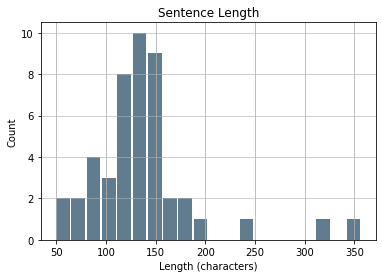

In [201]:
# Sentence length histogram
sentence_len = results['sentence'].apply(len)
size, scale = 1000, 10

sentence_len.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Sentence Length')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

In [24]:
# Save all results
results.to_csv('wnlu_results.csv',index=False)

### Load Results from CSV

In [109]:
results = pd.read_csv('wnlu_results.csv')

results['sentiment'] = results['sentiment'].astype(dtype=float)
results['concepts'] = results['concepts'].apply(eval)
results['categories'] = results['categories'].apply(eval)
results['entities'] = results['entities'].apply(eval)

all_sentiments = results['sentiment'].to_list()
all_concepts = results['concepts'].to_list()
all_categories = results['categories'].to_list() 
all_entities = results['entities'].to_list()
results.head(3)


,sentence,sentiment,concepts,categories,entities
0,Deep learning has yielded some remarkable resu...,0.959867,"[(Deep learning, 0.98066), (Artificial intelli...","[(/education, 0.910424), (/education/language ...",[]
1,But one of the shortcomings (arguably) in curr...,0.810648,"[(Deep learning, 0.989938), (Machine learning,...","[(/education/language learning, 0.998111), (/t...","[(Number, one, 0.978348, 0.810648)]"
2,What is the significance of this current lack ...,0.000000,"[(Fermi level, 0.186441), (Awareness, 0.078391...","[(/science, 0.850526), (/education, 0.708469),...",[]


## Concepts

### Preprocessing

In [174]:
# Create Concept relations with relevance greater than e

e = 0.5
concept_nodes = {}
concept_keys = []
for concept in all_concepts:
    for i in range(len(concept)):
        c = concept[i][0]
        c_relv = concept[i][1]
        if c not in concept_nodes.keys() and c_relv > e:
            concept_nodes[c] = {}
            if c not in concept_keys:
                concept_keys.append(c)
        for j in range(len(concept)):
            if i != j:
                c2 = concept[j][0]
                c2_relv = concept[j][1]
                if c_relv > e and c2_relv > e:
                    if c2 not in concept_nodes[c].keys():
                        concept_nodes[c][c2] = 1
                        if c2 not in concept_keys:
                            concept_keys.append(c2)
                    else:
                        concept_nodes[c][c2] += 1
print(concept_nodes)   
print(len(concept_keys)) 

{'Deep learning': {'Artificial intelligence': 14, 'Machine learning': 15, 'Feature learning': 1, 'Ethics': 1, 'Inference': 1}, 'Artificial intelligence': {'Deep learning': 14, 'Machine learning': 14, 'Inference': 1, 'Decision tree': 1}, 'Machine learning': {'Deep learning': 15, 'Artificial intelligence': 14, 'Feature learning': 1, 'Ethics': 1, 'Decision tree': 1}, 'Ethics': {'Deep learning': 1, 'Machine learning': 1}, 'Dave Barker': {'The Uniques (Jamaican group)': 1, 'Lloyd Parks': 1}, 'The Uniques (Jamaican group)': {'Dave Barker': 1, 'Lloyd Parks': 1}, 'Lloyd Parks': {'Dave Barker': 1, 'The Uniques (Jamaican group)': 1}, 'Feature learning': {'Deep learning': 1, 'Machine learning': 1}, 'Discrimination': {'Racism': 1, 'Systemic bias': 1}, 'Racism': {'Discrimination': 1, 'Systemic bias': 1}, 'Systemic bias': {'Discrimination': 1, 'Racism': 1}, 'Das Model': {'Learning': 1, 'Movement for Democracy in Liberia': 6, 'Scientific modelling': 1, 'Prodrug': 1, 'Conceptual model': 1, 'Adversaria

In [175]:
# Concept frequency with relevance greater than e
concepts = {}
for c in all_concepts:
    for t in c:
        if t[1] >e:
            if t[0] not in concepts.keys():
                concepts[t[0]] = 1
            else:
                concepts[t[0]] += 1
print(len(concepts))

48


In [204]:
# Save Concept Frequency
d = [list(concepts.keys()), list(concepts.values())]
df_concepts = pd.DataFrame(np.array(d).T, columns=['Concepts','Count'])
df_concepts.to_csv('concepts.csv',index=False)
df_concepts.head()

In [168]:
# Create concept edges with its weight
added_nodes = []
weighted_edges = []
for key in concept_nodes.keys():
    if key not in added_nodes:
        s = concept_keys.index(key)
        added_nodes.append(key)
        for another in concept_nodes[key].keys():
            t = concept_keys.index(another)
            we = (s,t,concept_nodes[key][another], key, another)
            ew = (t,s,concept_nodes[key][another], another, key)
            if we not in weighted_edges and ew not in weighted_edges:
                weighted_edges.append(we)
        if len(concept_nodes[key].keys()) == 0:
            weighted_edges.append((s,s,0,key,key))
print(weighted_edges)

[(0, 1, 12, 'Deep learning', 'Artificial intelligence'), (0, 2, 12, 'Deep learning', 'Machine learning'), (0, 6, 1, 'Deep learning', 'Feature learning'), (0, 7, 1, 'Deep learning', 'Ethics'), (0, 14, 1, 'Deep learning', 'Inference'), (1, 2, 11, 'Artificial intelligence', 'Machine learning'), (1, 14, 1, 'Artificial intelligence', 'Inference'), (2, 7, 1, 'Machine learning', 'Ethics'), (2, 21, 1, 'Machine learning', 'Decision tree'), (3, 4, 1, 'Dave Barker', 'The Uniques (Jamaican group)'), (3, 5, 1, 'Dave Barker', 'Lloyd Parks'), (4, 5, 1, 'The Uniques (Jamaican group)', 'Lloyd Parks'), (8, 9, 1, 'Discrimination', 'Racism'), (8, 10, 1, 'Discrimination', 'Systemic bias'), (9, 10, 1, 'Racism', 'Systemic bias'), (11, 12, 1, 'Das Model', 'Movement for Democracy in Liberia'), (11, 13, 1, 'Das Model', 'Tool'), (15, 16, 1, 'Knowledge', 'Reason'), (15, 17, 1, 'Knowledge', 'Logic'), (16, 17, 1, 'Reason', 'Logic'), (17, 22, 1, 'Logic', 'Fuzzy logic'), (17, 23, 1, 'Logic', 'Many-valued logic'), (18

In [169]:
# Save the edges
df_edges = pd.DataFrame(weighted_edges, columns=['source','target','weight', 'source_name','target_name'])
df_edges.to_csv('concepts_edges.csv',index=False)

### Visualization Test

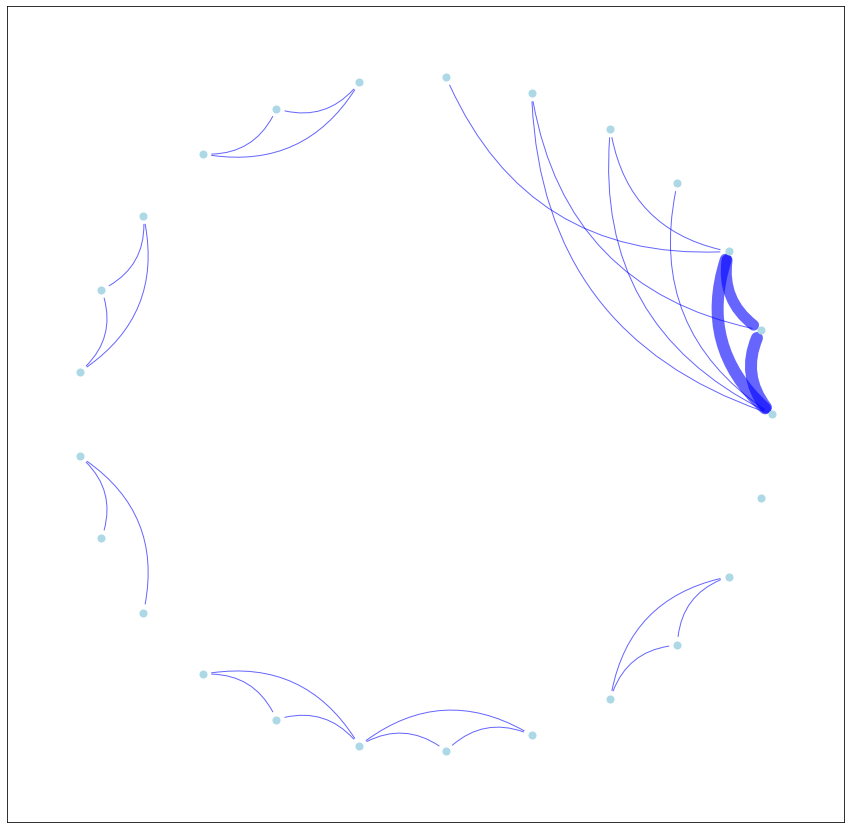

In [171]:
G=nx.from_pandas_edgelist(df_edges, 'source', 'target', ['weight','source_name','target_name'])
pos = nx.circular_layout(G, scale=2)

#nx.draw_networkx(G, pos)

weights = [G[u][v]['weight'] for u, v in G.edges()]
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw_networkx_edges(G, pos, ax=ax, width=weights, arrows=True, edge_color='blue', alpha=0.6, connectionstyle='arc3,rad=-0.35')
#text = nx.draw_networkx_labels(G, pos, ax=ax, font_size=9, horizontalalignment='left')
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')

#for _, t in text.items():
#    t.set_rotation('vertical') 
plt.show()

In [172]:
nodes_order = list(G.nodes())
starts = []
ends = []
for u, v in G.edges():
    if u == v:
        G.remove_edge(u,v)
    else:
        starts.append(nodes_order.index(u))
        ends.append(nodes_order.index(v))

In [173]:
import networkx as nx
import math
from bokeh.models import (BoxSelectTool, Circle, HoverTool, MultiLine,
                          NodesAndLinkedEdges, Plot, Range1d, TapTool, StaticLayoutProvider)
from bokeh.palettes import Spectral4, HighContrast
from bokeh.plotting import from_networkx, show


N = len(G.nodes())
node_indices = list(range(N))
plot = Plot(width=600, height=600,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Concepts Relations Network"
plot.title.text_font_size = '20pt'

plot.add_tools(HoverTool(tooltips='@name'), TapTool(), BoxSelectTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.data_source.data['name'] = [concept_keys[x] for x in G.nodes()]
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])
graph_renderer.edge_renderer.data_source.data['start'] = starts
graph_renderer.edge_renderer.data_source.data['end'] = ends

# create a static layout
circ = [i*2*math.pi/N for i in node_indices]
x = [math.cos(i) for i in circ]
y = [math.sin(i) for i in circ]
graph_layout = dict(zip(node_indices, zip(x, y)))
graph_renderer.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

# draw quadratic bezier paths
def bezier(start, end, control, steps):
    return [(1-s)**2*start + 2*(1-s)*s*control + s**2*end for s in steps]

graph_renderer.edge_renderer.data_source.data["line_width"] = [max(2,G.get_edge_data(a,b)['weight']) for a, b in G.edges()]

graph_renderer.edge_renderer.glyph = MultiLine(line_color=Spectral4[0], line_alpha=0.6)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2])
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1])

graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}
graph_renderer.edge_renderer.selection_glyph.line_width = {'field': 'line_width'}
graph_renderer.edge_renderer.hover_glyph.line_width = {'field': 'line_width'}

xs, ys = [], []
#sx, sy = graph_layout[0]
steps = [i/100. for i in range(100)]
for u, v in G.edges():
    sx, sy = graph_layout[nodes_order.index(u)]
    ex, ey = graph_layout[nodes_order.index(v)]
    cx = (sx+ex)/(abs(nodes_order.index(u) - nodes_order.index(v)) +1.5)
    cy = (sy+ey)/(abs(nodes_order.index(u) - nodes_order.index(v)) +1.5)
    xs.append(bezier(sx, ex, cx, steps))
    ys.append(bezier(sy, ey, cy, steps))

graph_renderer.edge_renderer.data_source.data['xs'] = xs
graph_renderer.edge_renderer.data_source.data['ys'] = ys

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph_renderer)
show(plot)

## Categories

In [228]:
# Categories frequency with confidence greater than e
e = 0.9
all_categories
categories = {}
for cat in all_categories:
    for t in cat:
        if t[1] >e:
            if t[0] not in categories.keys():
                categories[t[0]] = 1
            else:
                categories[t[0]] += 1
print(len(categories))

12


In [240]:
# Expand the hierarchies
arr = np.zeros( shape=(len(categories),4), dtype=object)
for k, key in enumerate(categories.keys()):
    filtered = list(filter(None, key.split('/')))
    N = len(filtered)
    if N==1:
        filtered = filtered*3
        filtered.append(categories[key])
        arr[k] = filtered
    elif N==2:
        filtered.append(filtered[-1])
        filtered.append(categories[key])
        arr[k] = filtered
    elif N==3:
        filtered.append(categories[key])
        arr[k] = filtered
    else:
        filtered.pop()
        filtered.append(categories[key])
        arr[k] = filtered
print(len(arr))

12


In [241]:
# Save the categories hierarchies
df_cat_her = pd.DataFrame(arr, columns=['Level_1', 'Level_2', 'Level_3', 'Count'])
df_cat_her.to_csv('categories_her.csv',index=False)
df_cat_her.head()

,Level_1,Level_2,Level_3,Count
0,education,education,education,7
1,education,language learning,language learning,9
2,technology & computing,artificial intelligence,artificial intelligence,3
3,news and politics,politics,political issues,1
4,family and relationships,parenting,adoption and fostering,1


In [407]:
# Save the categories frequencies
d = [list(categories.keys()), list(categories.values())]
df_categories = pd.DataFrame(np.array(d).T, columns=['Category','Count'])
df_categories.to_csv('categories.csv',index=False)

## Sentiment

In [6]:
# Save the sentiment per sentence
df_sentece_sentiment = results[['sentence','sentiment']]
df_sentece_sentiment.to_csv('sentece_sentiment.csv',index=False)

In [200]:
print(len(df_sentece_sentiment[df_sentece_sentiment['sentiment']<0]))
print(len(df_sentece_sentiment[df_sentece_sentiment['sentiment']==0]))
print(len(df_sentece_sentiment[df_sentece_sentiment['sentiment']>0]))

3
19
24


## Keywords

In [93]:
# Keyword extraction
from rake_nltk import Rake
rake_nltk_var = Rake()
max_k = 5
keywords = {}
for sentece in sentences:    
    rake_nltk_var.extract_keywords_from_text(sentece)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[:max_k]
    for kw in keyword_extracted:
        if kw not in keywords.keys():
            keywords[kw] = 1
        else:
            keywords[kw] += 1

print(keywords)
print(len(keywords))

# Merge similar keywords
kwkeys = list(keywords.keys())
for k, key in enumerate(kwkeys):
    for o, okey in enumerate(kwkeys):
        if key != okey:
            if key in okey and len(key.split(' '))>1:
                vokey = keywords[okey]
                keywords[key] += vokey
                keywords.pop(okey)
                kwkeys.pop(o)
            elif okey in key and len(okey.split(' '))>1:
                vkey = keywords[key]
                keywords[okey] += vkey
                keywords.pop(key)
                kwkeys.pop(k)
        elif len(key.split(' '))==1:
            keywords.pop(key)
            kwkeys.pop(k)

print(keywords)
print(len(keywords))


{'several commercially': 1, 'remarkable results': 1, 'recent years': 1, 'deep learning': 6, 'available tools': 1, 'current approaches': 1, 'learning': 3, 'unclear': 1, 'shortcomings': 1, 'current lack': 1, 'understanding': 2, 'significance': 1, 'ethical ramifications': 1, 'issue': 1, 'run viability': 2, 'techniques': 1, 'might': 1, 'long': 1, 'emerging': 1, 'deep learning methods': 2, 'significant challenge': 1, 'several reasons': 1, 'specific contexts': 1, 'methods': 2, 'limits': 1, 'improve': 2, 'first': 1, 'also raises concerns': 1, 'making systems': 2, 'automated decision': 1, 'transparency': 2, 'deep learning methods raises issues': 1, 'ethical perspective': 1, 'lack': 2, 'interpretability': 1, 'deep learning makes': 1, 'making process accountable': 1, 'making system based': 1, 'system arrived': 1, 'negative impact': 1, 'interpretability raises concerns': 1, 'furthermore': 1, 'discrimination': 1, 'bias': 1, 'training data contains biased': 1, 'model may learn': 1, 'certain groups 

In [94]:
# Create Keyword dataframe

d = [list(keywords.keys()), list(keywords.values())]
df_keywords = pd.DataFrame(np.array(d).T, columns=['keywords','count'])
df_keywords['count'] = df_keywords['count'].astype(dtype=float)

In [95]:
# Save keywords filtered frequency greater than 1
df_keywords = df_keywords[df_keywords['count']>1].sort_values(by=['count','keywords']).reset_index(drop=True)
df_keywords.to_csv('keywords.csv',index=False)
df_keywords.head(3)

,keywords,count
0,adversarial testing,2.0
1,based systems,2.0
2,bayesian networks,2.0
3,better understanding,2.0
4,decision trees,2.0
5,ensemble methods,2.0
6,explainability tools,2.0
7,fuzzy logic,2.0
8,make decisions,2.0
9,making systems,2.0
